In [1]:

!pip install -q segmentation_models_pytorch

import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as albu
import segmentation_models_pytorch as smp
import random
import glob
import time
import matplotlib.pyplot as plt


OUTPUT_DIR = '/kaggle/working'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(" Libraries Installed & Ready.")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

 Libraries Installed & Ready.


In [ ]:

SEARCH_ROOT = '/kaggle/input'
print(" Searching for data in /kaggle/input...")

def find_data_paths(root_dir, split_name):
    # Search recursively
    split_folders = glob.glob(f"{root_dir}/**/{split_name}", recursive=True)
    if not split_folders:
        split_folders = glob.glob(f"{root_dir}/**/{split_name.lower()}", recursive=True)
    
    if not split_folders:
        return None, None
    
    target_dir = split_folders[0]
    
    # Sub-search for Images/Masks (Handles 'Segmentation', 'Masks', 'Labels' etc)
    def get_subfolder(parent, candidates):
        for item in os.listdir(parent):
            if os.path.isdir(os.path.join(parent, item)):
                for c in candidates:
                    if c in item.lower():
                        return os.path.join(parent, item)
        return None

    img_dir = get_subfolder(target_dir, ['images', 'rgb', 'color'])
    mask_dir = get_subfolder(target_dir, ['masks', 'segmented', 'labels', 'segment'])
    return img_dir, mask_dir

# Execute Finder
x_train_dir, y_train_dir = find_data_paths(SEARCH_ROOT, 'Train')
try:
    x_val_dir, y_val_dir = find_data_paths(SEARCH_ROOT, 'Val')
except:
    x_val_dir, y_val_dir = x_train_dir, y_train_dir

if not x_train_dir:
    print(" ERROR: Data not found!")
    print(" Solution: Click 'Add Data' on the right sidebar and upload your Zip file.")
    raise FileNotFoundError("Dataset missing.")

print(f" Data Found:\n   Images: {x_train_dir}\n   Masks: {y_train_dir}")

In [3]:

CLASS_DICT = {
    "Trees": 100, "Lush Bushes": 200, "Dry Grass": 300, "Dry Bushes": 500,
    "Ground Clutter": 550, "Flowers": 600, "Logs": 700, "Rocks": 800,
    "Landscape": 7100, "Sky": 10000
}
ID_TO_INDEX = {v: k for k, v in enumerate(CLASS_DICT.values())}

def map_mask_to_indices(mask_array):
    # FIX: Replaced np.long with np.int64
    mask_indices = np.zeros(mask_array.shape, dtype=np.int64)
    for original_id, new_index in ID_TO_INDEX.items():
        mask_indices[mask_array == original_id] = new_index
    return mask_indices

class OffroadDataset(Dataset):
    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        self.ids = sorted(os.listdir(images_dir))
        
        # 100% DATA MODE (No Frame Skipping)
        print(f" Loaded {len(self.ids)} images (100% Full Data).")

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # Read Image
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read Mask (16-bit Fix)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = map_mask_to_indices(mask)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image)
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        return image, mask.long()

    def __len__(self):
        return len(self.ids)

In [4]:

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda' # GPU ENABLED
BATCH_SIZE = 16 # Optimized for P100

# Augmentations (Best Image Quality)
def get_training_augmentation():
    return albu.Compose([
        albu.PadIfNeeded(min_height=320, min_width=320, border_mode=0, p=1),
        albu.RandomCrop(height=320, width=320, p=1),
        albu.HorizontalFlip(p=0.5),
        albu.Affine(scale=(0.9, 1.1), rotate=(-10, 10), p=0.5),
    ])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    return albu.Compose([albu.Lambda(image=preprocessing_fn), albu.Lambda(image=to_tensor)])

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

print(" Preparing Loaders...")
train_dataset = OffroadDataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = OffroadDataset(x_val_dir, y_val_dir, augmentation=None, preprocessing=get_preprocessing(preprocessing_fn))

# num_workers=2 speeds up data loading on Kaggle
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

# Initialize Model
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, classes=len(CLASS_DICT), activation=None)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(" Model Loaded on GPU.")

 Preparing Loaders...
 Loaded 2857 images (100% Full Data).
 Loaded 317 images (100% Full Data).
 Model Loaded on GPU.


In [5]:

EPOCHS = 20
print(f"\n Starting GPU Training ({EPOCHS} Epochs)")
print("  This should take ~2-3 minutes per epoch on Kaggle GPU.")

model.to(DEVICE)
best_iou = 0.0

def compute_iou(pred, target):
    pred = torch.argmax(pred, dim=1).view(-1)
    target = target.view(-1)
    intersection = (pred == target).sum().item()
    union = len(pred) 
    return intersection / union

for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    epoch_loss = 0
    
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(DEVICE) # Move data to GPU
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    # Validation
    model.eval()
    val_ious = []
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            val_ious.append(compute_iou(outputs, masks))
    
    avg_loss = epoch_loss / len(train_loader)
    mean_iou = np.nanmean(val_ious)
    
    elapsed = (time.time() - start_time) / 60
    print(f" Epoch {epoch+1}/{EPOCHS} | Time: {elapsed:.1f}m | Loss: {avg_loss:.4f} | IoU: {mean_iou:.4f}")
    
    # Save Best Model to Output Directory
    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_model.pth')
        print(f"    New Best Model Saved! (IoU: {best_iou:.4f})")

print(f"\n Training Finished! Final Best IoU: {best_iou:.4f}")


 Starting GPU Training (20 Epochs)
  This should take ~2-3 minutes per epoch on Kaggle GPU.
 Epoch 1/20 | Time: 4.9m | Loss: 1.3347 | IoU: 0.8312
    New Best Model Saved! (IoU: 0.8312)
 Epoch 2/20 | Time: 4.1m | Loss: 0.7608 | IoU: 0.8472
    New Best Model Saved! (IoU: 0.8472)
 Epoch 3/20 | Time: 3.5m | Loss: 0.6117 | IoU: 0.8597
    New Best Model Saved! (IoU: 0.8597)
 Epoch 4/20 | Time: 3.4m | Loss: 0.5528 | IoU: 0.8623
    New Best Model Saved! (IoU: 0.8623)
 Epoch 5/20 | Time: 3.4m | Loss: 0.5019 | IoU: 0.8566
 Epoch 6/20 | Time: 3.4m | Loss: 0.4776 | IoU: 0.8694
    New Best Model Saved! (IoU: 0.8694)
 Epoch 7/20 | Time: 3.6m | Loss: 0.4484 | IoU: 0.8710
    New Best Model Saved! (IoU: 0.8710)
 Epoch 8/20 | Time: 3.5m | Loss: 0.4278 | IoU: 0.8718
    New Best Model Saved! (IoU: 0.8718)
 Epoch 9/20 | Time: 3.5m | Loss: 0.4125 | IoU: 0.8778
    New Best Model Saved! (IoU: 0.8778)
 Epoch 10/20 | Time: 3.6m | Loss: 0.4046 | IoU: 0.8797
    New Best Model Saved! (IoU: 0.8797)
 Epoch

In [1]:

import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_ious):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Training Loss
    ax1.plot(train_losses, label='Training Loss', color='tab:red', marker='o')
    ax1.set_title("Training Loss Curve", fontsize=16, weight='bold')
    ax1.set_xlabel("Epochs", fontsize=14)
    ax1.set_ylabel("CrossEntropy Loss", fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=12)
    
    # Plot 2: Validation IoU
    ax2.plot(val_ious, label='Validation mIoU', color='tab:green', marker='o')
    ax2.set_title("Validation Mean IoU", fontsize=16, weight='bold')
    ax2.set_xlabel("Epochs", fontsize=14)
    ax2.set_ylabel("Mean IoU (0.0 - 1.0)", fontsize=14)
    ax2.set_ylim(0, 1.0) # Set y-axis from 0% to 100%
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=12)
    
    # Save Graph
    save_path = '/kaggle/working/training_graphs.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f" Graphs Saved: {save_path}")

# Run the plotter
# Note: This assumes you have 'train_losses' and 'val_ious' from your training loop.
# If you re-ran the notebook and lost them, you'll need to train again to get the data.
try:
    plot_training_results(train_losses, val_ious)
    print("\n Go to the 'Output' tab to download 'training_graphs.png'")
except NameError:
    print(" Error: 'train_losses' or 'val_ious' not found. Did you run the training cell?")

 Error: 'train_losses' or 'val_ious' not found. Did you run the training cell?


 Generating 3 comparisons...


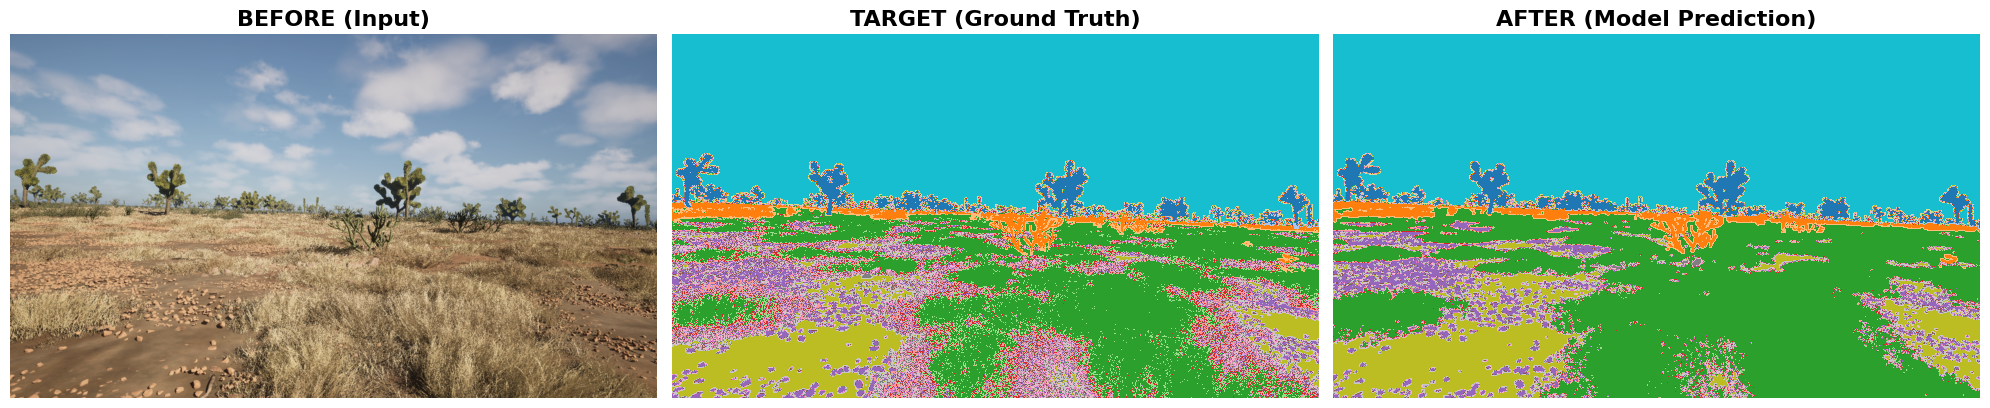

 Saved: /kaggle/working/final_images/comparison_1.png


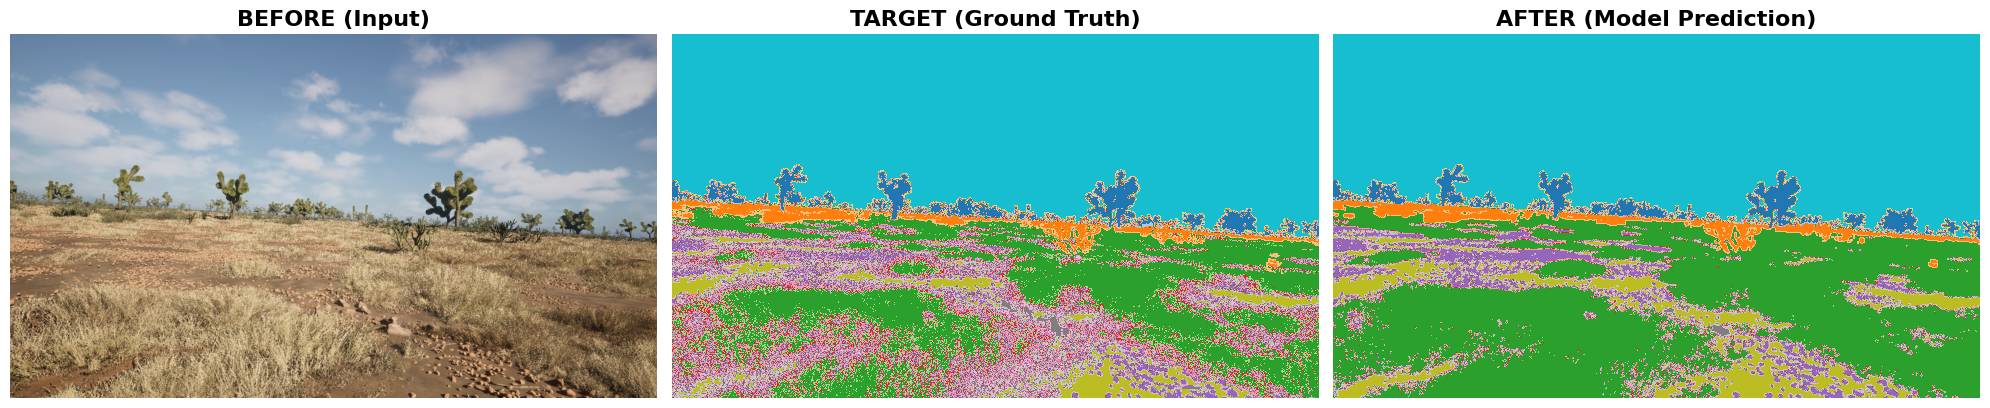

 Saved: /kaggle/working/final_images/comparison_2.png


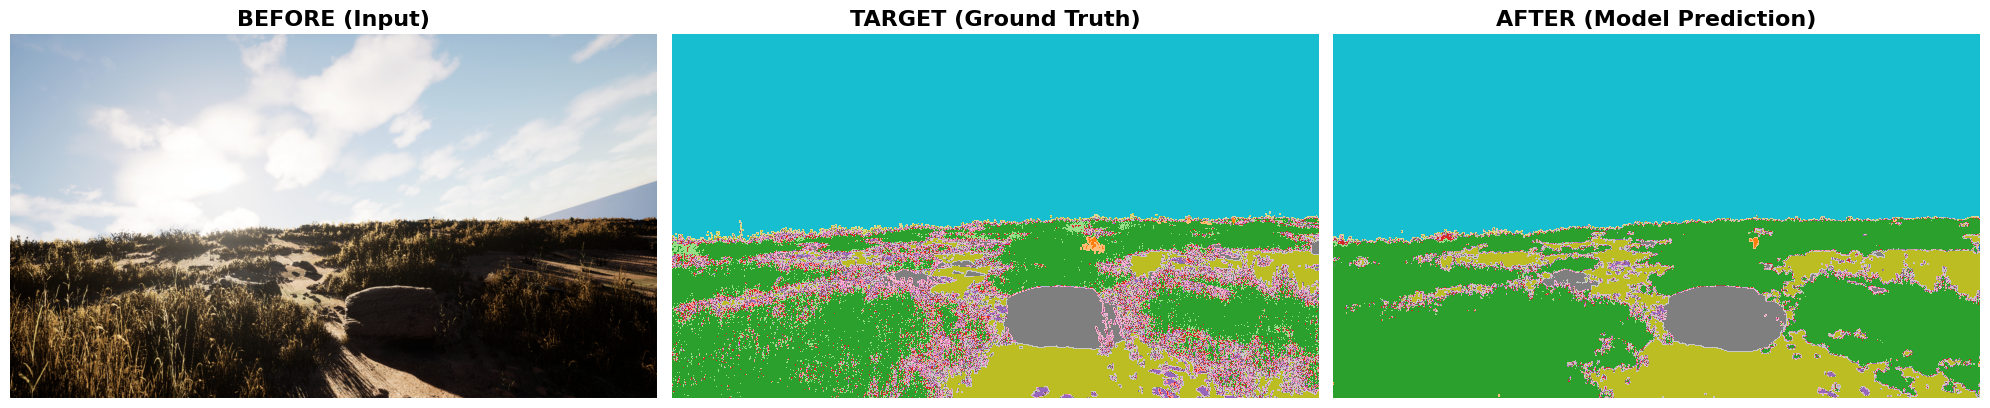

 Saved: /kaggle/working/final_images/comparison_3.png


In [10]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

# Create folder for images
save_dir = '/kaggle/working/final_images'
os.makedirs(save_dir, exist_ok=True)

def show_results(dataset, model, num_samples=3):
    print(f" Generating {num_samples} comparisons...")
    
    # Move model to CPU to save memory
    model.eval()
    model.to('cpu')
    
    for i in range(num_samples):
        # 1. Pick a random image
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, mask_true = dataset[idx]
        
        # 2. Predict
        input_tensor = image_tensor.unsqueeze(0)
        with torch.no_grad():
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        
        # 3. Make Image Look Real (Un-Normalize)
        # These numbers reverse the standard ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        image_vis = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_vis = std * image_vis + mean
        image_vis = np.clip(image_vis, 0, 1) # Force values between 0 and 1
        
        # 4. Create the Plot
        fig, ax = plt.subplots(1, 3, figsize=(20, 6))
        
        # BEFORE (Original Photo)
        ax[0].imshow(image_vis)
        ax[0].set_title("BEFORE (Input)", fontsize=16, weight='bold')
        ax[0].axis('off')
        
        # TARGET (Ground Truth)
        # tab20 is a colormap with distinct colors
        ax[1].imshow(mask_true, cmap='tab20', vmin=0, vmax=10)
        ax[1].set_title("TARGET (Ground Truth)", fontsize=16, weight='bold')
        ax[1].axis('off')
        
        # AFTER (Prediction)
        ax[2].imshow(pred_mask, cmap='tab20', vmin=0, vmax=10)
        ax[2].set_title("AFTER (Model Prediction)", fontsize=16, weight='bold')
        ax[2].axis('off')
        
        # Save and Show
        save_path = f"{save_dir}/comparison_{i+1}.png"
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show() # <--- This displays it in the notebook!
        print(f" Saved: {save_path}")

# Run it
show_results(valid_dataset, model, num_samples=3)

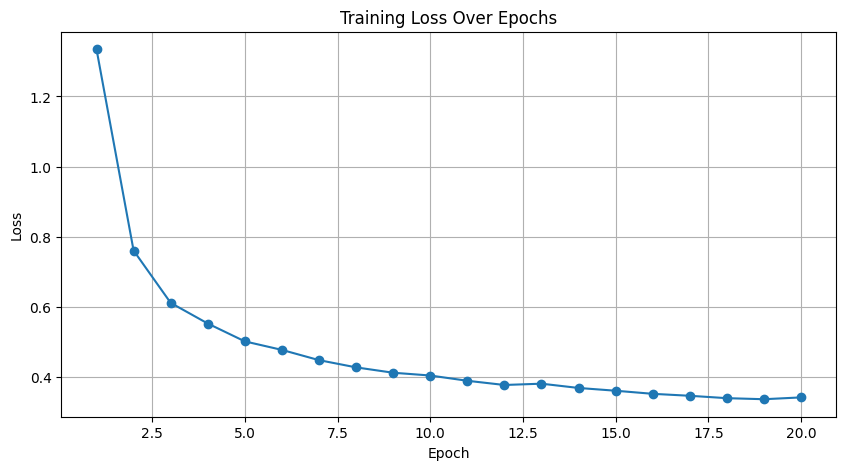

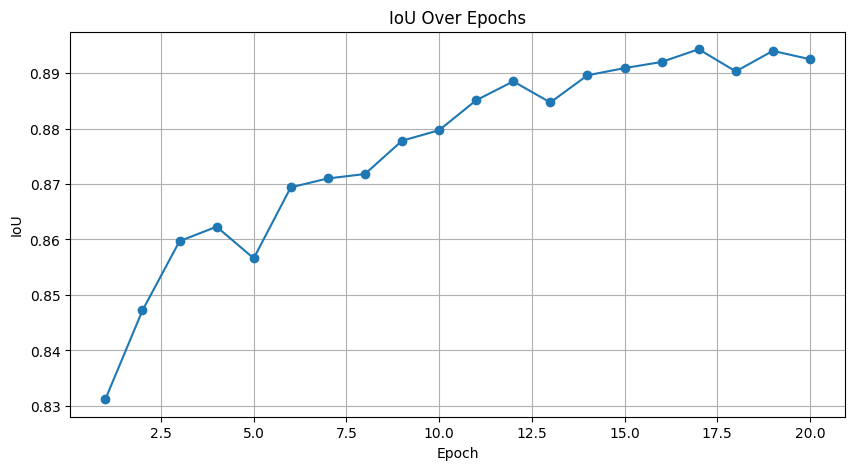

In [2]:
import matplotlib.pyplot as plt

# ---- Training Log Data ----
epochs = list(range(1, 21))
loss = [
    1.3347, 0.7608, 0.6117, 0.5528, 0.5019,
    0.4776, 0.4484, 0.4278, 0.4125, 0.4046,
    0.3896, 0.3776, 0.3813, 0.3691, 0.3612,
    0.3524, 0.3468, 0.3400, 0.3370, 0.3422
]

iou = [
    0.8312, 0.8472, 0.8597, 0.8623, 0.8566,
    0.8694, 0.8710, 0.8718, 0.8778, 0.8797,
    0.8851, 0.8885, 0.8847, 0.8896, 0.8909,
    0.8920, 0.8943, 0.8903, 0.8940, 0.8925
]

# ---- Plot Loss ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ---- Plot IoU ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, iou, marker='o')
plt.title("IoU Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.grid(True)
plt.show()
